In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import exercise5
import logging
import exercise6

from typing import List

In [49]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [2]:
def fQS(
        u_c: List[float], alpha: float, beta: float,
        gamma: float, u_tresh: float, n: int
    ):
    return alpha + beta*u_c**n/(u_tresh**n + u_c**n) - gamma*u_c

In [3]:
alpha = 1
beta = 100
u_tresh = 2
gamma = 0
n = 10
u_c = np.linspace(0, 5, 400)
f = fQS(u_c, alpha, beta, gamma, u_tresh, n)

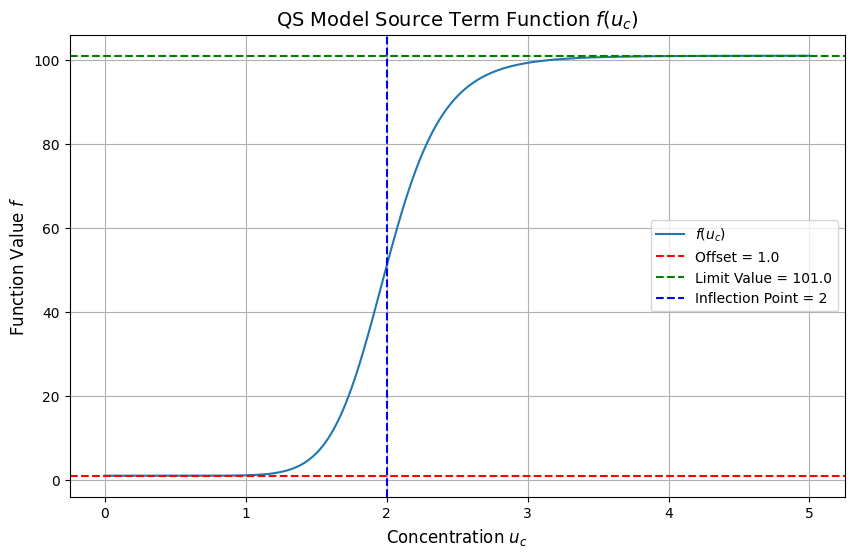

In [4]:
offset = fQS(0, alpha, beta, gamma, u_tresh, n)
limit_value = fQS(np.inf, alpha, beta, gamma, u_tresh, n)  # This simplifies to alpha + beta
inflection_point = u_tresh

large_u_c = 1e6
limit_value_numerical = fQS(large_u_c, alpha, beta, gamma, u_tresh, n)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(u_c, f, label='$f(u_c)$')
plt.axhline(y=offset, color='r', linestyle='--', label=f'Offset = {offset}')
plt.axhline(y=limit_value_numerical, color='g', linestyle='--', label=f'Limit Value = {limit_value_numerical}')
plt.axvline(x=inflection_point, color='b', linestyle='--', label=f'Inflection Point = {inflection_point}')
plt.title('QS Model Source Term Function $f(u_c)$', fontsize=14)
plt.xlabel('Concentration $u_c$', fontsize=12)
plt.ylabel('Function Value $f$', fontsize=12)
plt.legend()
plt.grid(True)

In [5]:
def applyQS(u_e, u_c, alpha, beta, gamma, u_tresh, n, d1, d2):
    du_c = fQS(u_c, alpha, beta, gamma, u_tresh, n) + d1 * u_e - d2 * u_c
    du_e = -d1 * u_e + d2 * u_c - gamma * u_e
    return [du_c, du_e]

In [79]:
D = 1
T = 20
num_particles = 51
d1, d2 = 0.25, 2.5
alpha, beta = 1, 100
gamma = 0.5
l_bound, u_bound = 0, 50
dx = (u_bound - l_bound)/(num_particles - 1)
h = (u_bound - l_bound) / ((num_particles**2)**(1/2))
dt = h**2/(4*D)
epsilon = h
cell_side = cutoff = 3*epsilon
u_tresh = 2
n = 10

In [80]:
V = np.ones(num_particles**2)*h**2
x = np.linspace(l_bound, u_bound, num_particles)
y = np.linspace(l_bound, u_bound, num_particles)

X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T

particle_matrix, cell_list, num_cells = exercise5.get_cell_list(positions, l_bound, u_bound, cell_side)
verlet = exercise5.get_verlet_list_2d(cell_list, particle_matrix, num_cells, cutoff)

In [81]:
total_u_e = []
total_u_c = []
center_index = num_particles // 2
u_c = np.zeros([num_particles, num_particles])
u_e = np.zeros([num_particles, num_particles])
u_c[center_index][center_index] = u_tresh
u_c, u_e = u_c.flatten(), u_e.flatten()
for t in np.arange(0, T, dt):
    logging.info(f'Starting iteration at time {t:.4f}.')
    u_e_diffused = exercise6.pse_diffusion_2d(D, epsilon, u_e, positions, verlet, num_particles**2, V)
    u_c_diffused = exercise6.pse_diffusion_2d(D, epsilon, u_c, positions, verlet, num_particles**2, V)

    du_c, du_e = applyQS(u_e_diffused, u_c_diffused, alpha, beta, gamma, u_tresh, n, d1, d2)

    u_e += (u_c_diffused + du_e)*dt
    u_c += (u_e_diffused + du_c)*dt

    total_u_e.append(np.sum(u_e))
    total_u_c.append(np.sum(u_c))

2024-07-01 12:40:49,487 - Starting iteration at time 0.0000.


2024-07-01 12:40:51,301 - Starting iteration at time 0.0577.
2024-07-01 12:40:53,017 - Starting iteration at time 0.1155.
2024-07-01 12:40:54,747 - Starting iteration at time 0.1732.
2024-07-01 12:40:56,398 - Starting iteration at time 0.2310.
2024-07-01 12:40:58,115 - Starting iteration at time 0.2887.
2024-07-01 12:40:59,893 - Starting iteration at time 0.3464.
2024-07-01 12:41:01,669 - Starting iteration at time 0.4042.
2024-07-01 12:41:03,487 - Starting iteration at time 0.4619.
2024-07-01 12:41:05,256 - Starting iteration at time 0.5197.
2024-07-01 12:41:06,980 - Starting iteration at time 0.5774.
2024-07-01 12:41:08,611 - Starting iteration at time 0.6351.
2024-07-01 12:41:10,373 - Starting iteration at time 0.6929.
2024-07-01 12:41:12,206 - Starting iteration at time 0.7506.
2024-07-01 12:41:13,923 - Starting iteration at time 0.8084.
2024-07-01 12:41:15,641 - Starting iteration at time 0.8661.
2024-07-01 12:41:17,485 - Starting iteration at time 0.9238.
2024-07-01 12:41:19,223 

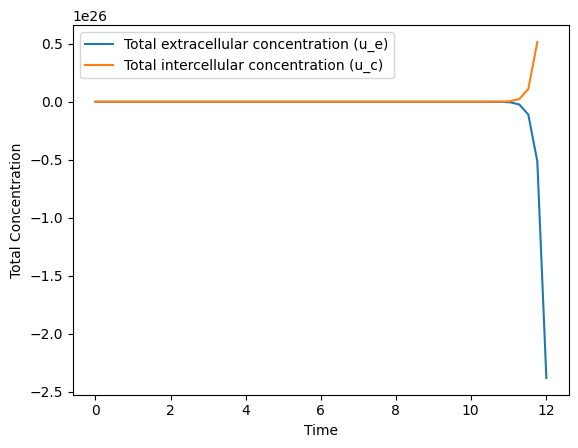

In [84]:
plt.plot(np.arange(0, T, dt), total_u_e, label='Total extracellular concentration (u_e)')
plt.plot(np.arange(0, T, dt), total_u_c, label='Total intercellular concentration (u_c)')
plt.xlabel('Time')
plt.ylabel('Total Concentration')
plt.legend()
plt.show()